In [1]:
import numpy as np
import matplotlib.pyplot as plt
import MySQLdb, pickle
import pandas as pd
from sqlalchemy import create_engine
from collections import Counter

In [2]:
# Read car_info from MySQL at Amazon Web Service Cloud 
pw = pickle.load(open('./Flask/models/pw.plk','rb'))

db = MySQLdb.connect(
    "ec2-34-219-13-119.us-west-2.compute.amazonaws.com",
    "root",
    pw,
    "car",
    charset='utf8',
)

# SQL Query
SQL_QUERY = """
    SELECT *
    FROM car;
"""

# Bring car information from MySQL into dataframe
train = pd.read_sql(SQL_QUERY, db)
train.head()

,index,title,year,brand,model,miles,star,review_no,price
0,0,2018 ford f-150 platinum,2018,ford,f-150 platinum,58432,4.9,1438,51995
1,1,2018 ford f-150 platinum,2018,ford,f-150 platinum,45277,4.5,464,51125
2,2,2015 lexus gx 460 base,2015,lexus,gx 460 base,97028,2.8,28,31992
3,3,2019 bmw 740 i,2019,bmw,740 i,26535,4.5,642,56995
4,4,2018 bmw x2 sdrive28i,2018,bmw,x2 sdrive28i,14693,4.1,569,33500


In [3]:
# Saving data to the database
pickle.dump(train, open("./Flask/models/database.plk","wb"))

In [4]:
# Top 50 car brands
brand_list = []
for brand in Counter(train.brand).most_common(50):
    brand_list.append(brand[0])

In [5]:
# Check the index of data not included in the top 50 car brands
idx_list = []
idx = 0
for i in train["brand"]:
    if i not in brand_list:
        idx_list.append(idx)
    idx += 1

In [6]:
# Only the top 50 car brands are filtered
train = train.drop(idx_list)
train.reset_index(drop=True, inplace=True)
train = train.drop("index", axis=1)

### Feature engineering

In [7]:
# Select models and brands as category variables
categorical_features = ['brand', 'model']

In [8]:
# Dummy category variable
dummy_cat = pd.get_dummies(train[categorical_features])
dummy_cat.head()

,brand_audi,brand_bmw,brand_chevrolet,brand_ford,brand_land,brand_lexus,brand_mercedes-benz,brand_tesla,brand_toyota,model_330 i,...,model_gx 460 base,model_model 3 mid range,model_q7 3.0t premium plus,model_rover range rover 3.0l supercharged hse,model_rover range rover sport 3.0l supercharged hse,model_rover range rover sport hse,model_rover range rover velar p380 hse r-dynamic,model_x2 sdrive28i,model_x2 xdrive28i,model_x5 xdrive40i
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [9]:
# Select year, miles, price by numeric variable
# Select by numeric variable
numerical_features = ['year', 'miles','price']

In [10]:
np.log1p(train[numerical_features])

,year,miles,price
0,7.610358,10.975636,10.858922
1,7.610358,10.720577,10.842048
2,7.608871,11.482765,10.373272
3,7.610853,10.186258,10.950736
4,7.610358,9.595195,10.419331
5,7.611348,9.815039,11.325402
6,7.609862,10.485563,11.049317
7,7.609862,11.263900,10.518430
8,7.609862,10.513552,11.125806
9,7.610853,10.364923,10.968078


In [11]:
# Normalized numeric Variables
normalize_num = np.log1p(train[numerical_features])
normalize_num.head()

,year,miles,price
0,7.610358,10.975636,10.858922
1,7.610358,10.720577,10.842048
2,7.608871,11.482765,10.373272
3,7.610853,10.186258,10.950736
4,7.610358,9.595195,10.419331


In [12]:
# Join numeric variable with categoric variable
X_train_0 = normalize_num.join(dummy_cat)

# Seperate price as y value
y_train = X_train_0["price"]
X_train = X_train_0.drop("price", axis=1)

### Model : XGBoost Model
XGBoost is short for “Extreme Gradient Boosting”, where the term “Gradient Boosting” is proposed in the paper Greedy Function Approximation: A Gradient Boosting Machine, by Friedman. XGBoost is based on this original model.

XGBoost is used for supervised learning problems, where we use the training data (with multiple features) x to predict a target variable y. Before we dive into trees, let us start by reviewing the basic elements in supervised learning.

In [13]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# K-ford : 10
k_fold = KFold(n_splits=10, shuffle=True, random_state=2018)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, y_train)

In [14]:
# Create XGBoost Regressor model
ml = XGBRegressor(n_estimators=1000, learning_rate=0.05, verbose=False)

In [15]:
# Check the corss validation score
%time score = cross_val_score(ml, X_train, y_train, cv=k_fold, n_jobs=-1, scoring="r2").mean()
print("Score = {0:.5f}".format(score))

[05:51:38] WARNING: ../src/learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:51:40] WARNING: ../src/learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[05:51:42] WARNING: ../src/learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting

[05:52:07] WARNING: ../src/learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




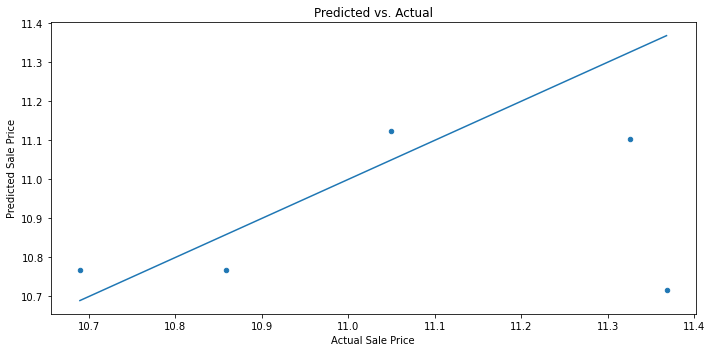

In [16]:
# Train model
ml = ml.fit(X_train1, y_train1)

# Predict test data set
y_pred = ml.predict(X_test1)

# Drawing regression graph
plt.figure(figsize=(10, 5))
plt.scatter(y_test1, y_pred, s=20)
plt.title('Predicted vs. Actual')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')

plt.plot([min(y_test1), max(y_test1)], [min(y_test1), max(y_test1)])
plt.tight_layout()

In [17]:
# Save the model to the pickle file
pickle.dump(ml, open("./Flask/models/model.plk","wb"))

In [18]:
# Set up a dataset using "brand", "model", "year", "miles", "price"
actual_car_info = train[["brand", "model","year","miles","price"]]

# Save the dataset to the pickle file
pickle.dump(actual_car_info, open("./Flask/models/actual_car_info.plk","wb"))

### Enter Used Car information

In [19]:
# Enter the information of the vehicle you want to know about the estimated price of used car
brand = str(input("brand: "))
model = str(input("model: "))
year = int(input("year: "))
miles = int(input("miles: "))

brand: kia
model: forte
year: 2020
miles: 70000


In [20]:
# Save the variable column used to train the model as a data frame
target = pd.DataFrame(columns = [X_train1.columns])

In [21]:
# Save the variable column to the pickle file
pickle.dump(X_train1.columns, open("./Flask/models/column.plk","wb"))

In [22]:
# Check the index location of the selected used car brand in the variable column data frame
brand_index = 0
for col in X_train1.columns:
    if col == 'brand'+"_"+brand:
        break;
    brand_index += 1
brand_index

25

In [23]:
# Check the index location of the selected used car model in the variable column data frame
model_index = 0
for col in X_train1.columns:
    if col == 'model'+"_"+model:
        break;
    model_index += 1
model_index

224

In [24]:
# Array of zeros
target_list = np.zeros_like(X_train1.loc[0])

In [25]:
# Save the target_list to pickle file
pickle.dump(target_list, open("./Flask/models/target_list.plk","wb"))

In [26]:
# Put the number 1 in the selected brand and model locations in the data frame
target_list[brand_index] = 1
target_list[model_index] = 1

# Put the year and miles in the data frame
target_list[0] = year
target_list[1] = miles

In [27]:
# Insert data into target data frame 
for i in range(1):
    target.loc[i] = target_list

In [28]:
# Nomalizing numerical features
numerical_features = ['year', 'miles']
normalize_target  = np.log1p(target[numerical_features])

In [29]:
target.drop(['year', 'miles'], axis=1, inplace=True)

/home/ubuntu/.local/lib/python3.8/site-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [30]:
target_goal = normalize_target.join(target)

In [31]:
target_goal

,year,miles,brand_acura,brand_alfa,brand_am,brand_audi,brand_bentley,brand_bmw,brand_buick,brand_cadillac,...,model_xt4,model_xt5,model_xt6,model_xterra,model_xts,model_xv,model_yaris,model_yukon,model_z3,model_z4
0,7.611348,11.156265,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Predict Used_Car Values

In [32]:
# Predicted logged price
price_log = ml.predict(target_goal)

In [33]:
price_log

array([9.338268], dtype=float32)

In [34]:
# Revert the logged price back to its original price
price = np.exp(price_log)
print("Price:", int(price))

Price: 11364


### Compare same model with different years

In [35]:
# Find the average of the same model for each year
same_model = actual_car_info[actual_car_info["model"]==model] 
year_price = same_model[["year", "price"]]
year_price_list = year_price.groupby("year").agg({'price':np.mean}).astype('int')
year_price_list = year_price_list.reset_index()
year_price_list

,year,price
0,2010,2000
1,2014,9998
2,2015,6472
3,2016,14590
4,2017,10999
5,2019,12621
6,2020,14273


In [36]:
# Convert year from number type to character type
year_price_list["year"] = year_price_list["year"].apply(lambda x: str(x) )

In [37]:
# Convert price from number type to character type
year_price_list["price"] = year_price_list["price"].apply(lambda x: str(x) )

In [38]:
list(year_price_list["price"])

['2000', '9998', '6472', '14590', '10999', '12621', '14273']